## Importing Necessary Libraries
This section includes import statements for the necessary libraries:
- Standard libraries like `json` for handling JSON files.
- Third-party libraries such as `numpy`, `matplotlib`, `seaborn`, `tensorflow`, and `sklearn` for data manipulation, visualization, machine learning, and deep learning tasks.



In [5]:
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

## Specifying the Dataset Path
This line sets the path to the dataset:
- `json_data_path` (str): The file path to the JSON file containing the dataset.


In [6]:
json_data_path = "git.json"

## Configuring TensorFlow for GPU Usage
Two functions are defined here to configure and test TensorFlow's GPU usage:

1. `configure_gpu`: This function checks for the availability of a GPU and configures TensorFlow to use it if available. It returns `True` if a GPU is configured, otherwise `False`. Exception handling is included to catch and print any errors during configuration.

2. `gpu_test_computation`: This function performs a simple test computation on the GPU, if available. It multiplies two tensors and prints the result to demonstrate that the GPU is being used.

After defining these functions, TensorFlow's version is printed, and `configure_gpu` is called to configure the GPU. If successful, `gpu_test_computation` is executed to demonstrate GPU computation.

In [7]:
def configure_gpu():
    try:
        gpu_devices = tf.config.experimental.list_physical_devices('GPU')
        if not gpu_devices:
            print("No GPU devices found. TensorFlow will use CPU.")
            return False
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        return True
    except Exception as e:
        print(f"Error configuring TensorFlow to use GPU: {e}")
        return False


def gpu_test_computation():
    with tf.device('/GPU:0'):
        a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0])
        b = tf.constant([5.0, 4.0, 3.0, 2.0, 1.0])
        c = a * b
        print("Result of GPU computation:", c.numpy())


print(f"TensorFlow Version: {tf.__version__}")
if configure_gpu():
    gpu_test_computation()


TensorFlow Version: 2.10.1
Result of GPU computation: [5. 8. 9. 8. 5.]


## Loading Data from JSON
The function `load_data` is designed to load the dataset from a JSON file. It takes a single argument:
- `data_path` (str): The file path to the JSON dataset.

The function returns a tuple containing two elements:
- `X`: A NumPy array of extracted features (mfccs).
- `Y`: A NumPy array of corresponding labels.


In [9]:
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    Y = np.array(data["labels"])
    print('data successfully loaded ')
    return X, Y


try:
    X, Y = load_data(json_data_path)
except Exception as e:
    print(f"Error loading data: {e}")


data successfully loaded 


## Splitting Data into Training, Validation, and Test Sets
The `split_data` function divides the dataset into training, validation, and test sets.

Args:
- `test_size` (float): Proportion of the dataset to include in the test split.
- `validation_size` (float): Proportion of the training set to include in the validation split.

Returns:
- Tuple containing six datasets: `X_train`, `X_validation`, `X_test`, `y_train`, `y_validation`, and `y_test`.



In [10]:
def split_data(test_size, validation_size):
    X, Y = load_data(json_data_path)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


## Function for Plotting Training History
The `plot_history` function is designed for visualizing the training history of a machine learning model. Its parameters are as follows:

- `history` (History object): The training history returned by the `fit` method of a Keras model. Contains metrics recorded during training.
- `metrics` (list of str): Specifies the list of metrics to plot. Default is `['loss', 'accuracy']`. This allows for flexibility in choosing which metrics to visualize.
- `figsize` (tuple): Determines the size of the figure. This parameter allows customization of the plot's dimensions.
- `save_path` (str): The file path for saving the plot image. This provides flexibility in specifying where to save the generated plot.

The function generates a plot for each specified metric, comparing training and validation results. It saves the plot as an image at the specified `save_path` and displays it inline.



In [20]:
def plot_history(history, metrics=None, figsize=(16, 10), save_path='training_history.png'):
    if metrics is None:
        metrics = ['loss', 'accuracy']

    sn.set(style="whitegrid")
    plt.figure(figsize=figsize)
    color_palette = sn.color_palette("husl", len(metrics) * 2)

    for i, metric in enumerate(metrics):
        # Check if metric is in history
        if metric not in history.history:
            print(f"Warning: '{metric}' not found in history.")
            continue

        plt.subplot(2, 1, i + 1)
        plt.subplots_adjust(hspace=0.5)
        plt.plot(history.history[metric], label=f'Train {metric.capitalize()}', color=color_palette[i], linewidth=2)
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f'Validation {metric.capitalize()}', color=color_palette[i + 1], linewidth=2)
        plt.legend(frameon=True)
        plt.title(f'Training and Validation {metric.capitalize()}', fontsize=16)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(metric.capitalize(), fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


In [26]:
def plot_heatmap(cm, genre_labels, save_path='heatmap.png'):
    plt.figure(figsize=(10, 7))
    ax = sn.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

    ax.set_xticklabels(genre_labels)
    ax.set_yticklabels(genre_labels)

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.show()
    plt.savefig(save_path)

## Constructing a Convolutional Neural Network

The `build_model` function defines a convolutional neural network (CNN) for classification tasks. Key aspects of the function include:

- `input_shape` (tuple): The shape of the input data fed into the CNN.
- `num_classes` (int, default=10): The number of output classes for the classification. This is set to 10 by default but can be adjusted according to the specific dataset.

The CNN architecture includes:
- Three convolutional layers, each followed by max-pooling, batch normalization, and dropout layers. This is a common setup to extract features and reduce overfitting.
- After flattening the output from the convolutional layers, the network includes a dense layer with L2 regularization, followed by a dropout layer.
- The final layer is a dense layer with a softmax activation function, suitable for multi-class classification.

The function returns the constructed but uncompiled model, allowing for customization in the compilation step.


In [12]:
def build_model(input_shape):
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(256, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

## Making Predictions with the Model
The `predict` function is designed to make predictions using a trained machine learning model. Key aspects of the function include:

- `model`: The pre-trained machine learning model to use for making predictions.
    - `X`: The input data for which predictions are to be made. It is expected to be in a format compatible with the model's input shape.
- `y`: The true label associated with the input data.

In [13]:
genres = ['BLUES', 'CLASSICAL', 'COUNTRY', 'DISCO', 'HIPHOP', 'JAZZ', 'METAL', 'POP', 'REGGAE', 'ROCK']


def predict(model, X, y):
    X = X[np.newaxis, ...]

    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

    y = y.item()
    predicted_index = predicted_index.item()
    print("Target: " + genres[y] + ", Predicted Index: " + genres[predicted_index])

## Data Splitting and Model Setup
This code snippet performs data splitting and sets up a machine learning model. Here are the main function arguments and outputs:

- `split_data(test_size, validation_size)`:
  - Args:
    - `test_size` (float): Proportion of the dataset to include in the test split.
    - `validation_size` (float): Proportion of the training set to include in the validation split.
  - Returns:
    - A tuple containing six datasets: `X_train`, `X_validation`, `X_test`, `y_train`, `y_validation`, `y_test`.

- `build_model(input_shape)`:
  - Args:
    - `input_shape` (tuple): Shape of the input data for the model.
  - Returns:
    - The constructed machine learning model.

- Model Compilation (`model.compile`):
  - Args:
    - `optimizer` (Adam with a learning rate of 0.0001): Specifies the optimization algorithm.
    - `loss` ('sparse_categorical_crossentropy'): Defines the loss function for training.
    - `metrics` (['accuracy']): Specifies evaluation metrics.


In [14]:
X_train, X_validation, X_test, y_train, y_validation, y_test = split_data(0.2, 0.2)

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

data successfully loaded 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 64)        256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64, 6, 64)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 128)        73856     
                                                                 
 max_pooling2d_1 (MaxPooling  

In [15]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=150)

Epoch 1/150
200/200 [==============================] - 35s 12ms/step - loss: 2.8572 - accuracy: 0.2264 - val_loss: 2.0577 - val_accuracy: 0.3605
Epoch 2/150
200/200 [==============================] - 2s 9ms/step - loss: 2.2831 - accuracy: 0.3404 - val_loss: 1.8347 - val_accuracy: 0.4224
Epoch 3/150
200/200 [==============================] - 2s 9ms/step - loss: 2.0463 - accuracy: 0.3895 - val_loss: 1.7596 - val_accuracy: 0.4487
Epoch 4/150
200/200 [==============================] - 2s 9ms/step - loss: 1.9333 - accuracy: 0.4158 - val_loss: 1.6833 - val_accuracy: 0.4756
Epoch 5/150
200/200 [==============================] - 2s 8ms/step - loss: 1.8289 - accuracy: 0.4527 - val_loss: 1.6894 - val_accuracy: 0.4568
Epoch 6/150
200/200 [==============================] - 2s 8ms/step - loss: 1.7193 - accuracy: 0.4859 - val_loss: 1.6987 - val_accuracy: 0.4650
Epoch 7/150
200/200 [==============================] - 2s 8ms/step - loss: 1.6694 - accuracy: 0.4958 - val_loss: 1.6476 - val_accuracy: 0.48

In [16]:
model.save('git_modelv3.h5')

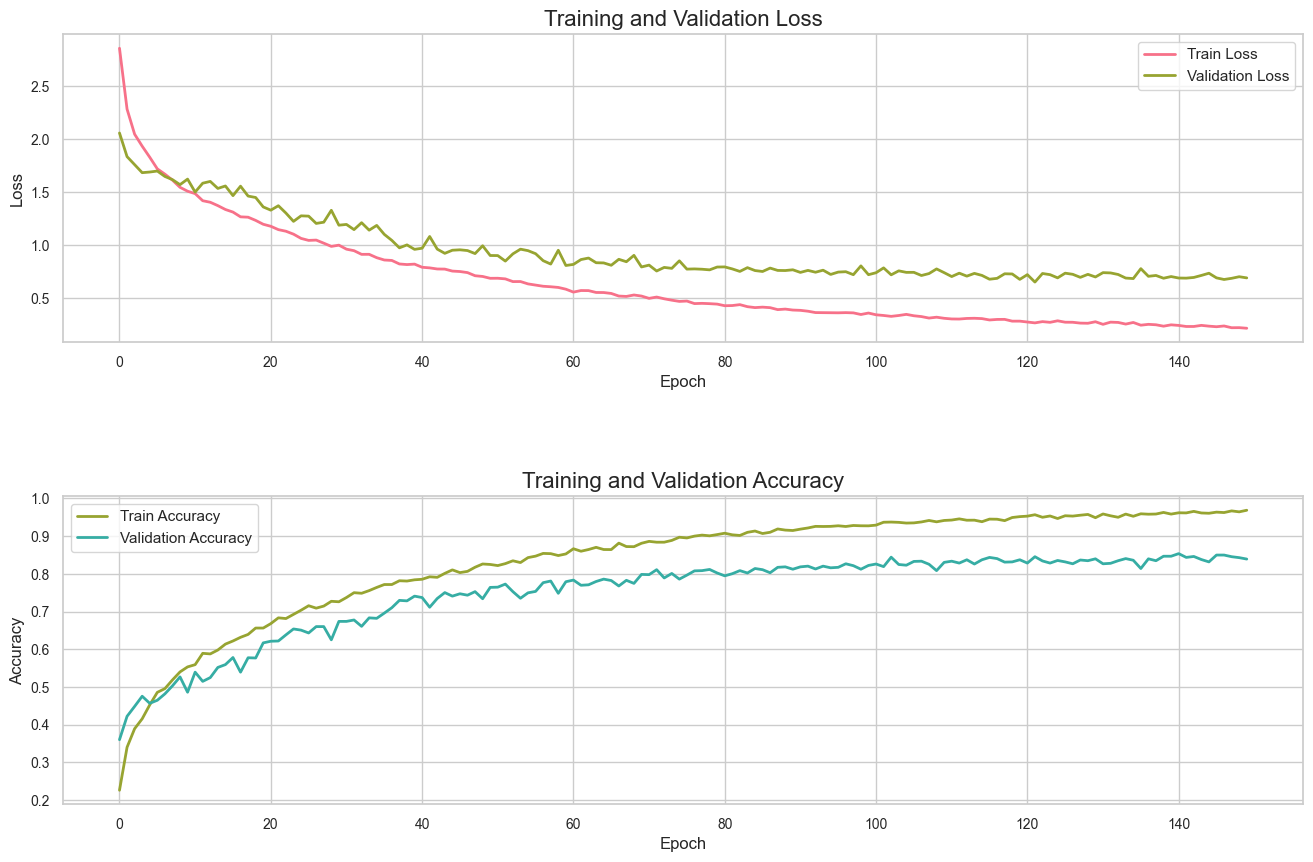

63/63 [==============================] - 1s 9ms/step - loss: 0.6628 - accuracy: 0.8498

Test accuracy: 0.8498498201370239


In [21]:
plot_history(history)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('\nTest accuracy:', test_acc)

In [30]:
y_predicted = model.predict(X_test)
y_predicted_labels = [np.argmax(i) for i in y_predicted]

print("Accuracy in Test Data : ", accuracy_score(y_test, y_predicted_labels))

63/63 [==============================] - 0s 6ms/step
Accuracy in Test Data :  0.8498498498498499


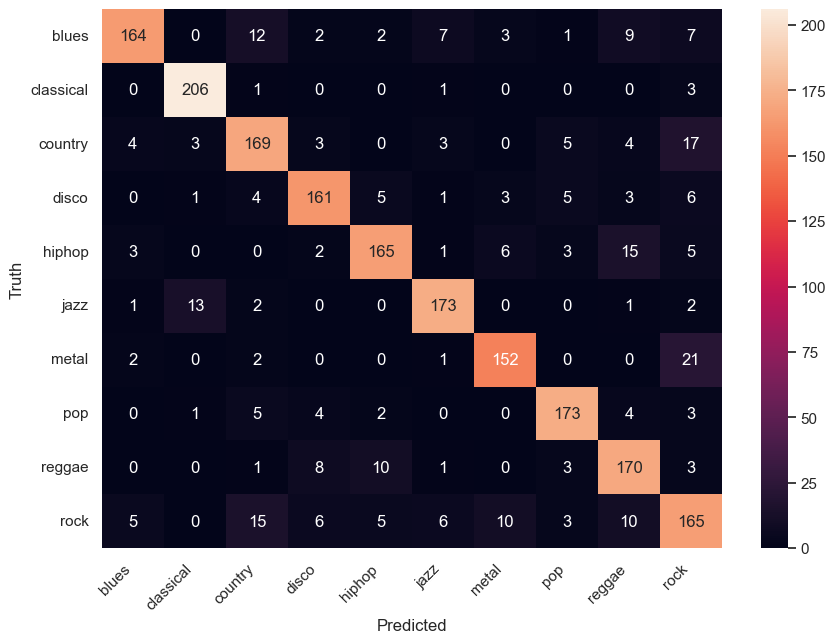

<Figure size 640x480 with 0 Axes>

In [31]:
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)
genre_labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
plot_heatmap(cm, genre_labels)

In [29]:
X_to_predict = X_test[100]
y_to_predict = y_test[100]

predict(model, X_to_predict, y_to_predict)

1/1 [==============================] - 0s 21ms/step
Target: 2, Predicted label: [2]
Target: COUNTRY, Predicted Index: COUNTRY
